[[ 0.          0.        ]
 [ 0.09686497  0.12559885]
 [ 0.16729788  0.47368716]
 [ 0.52249845  0.45680854]
 [ 0.49911226  0.01634802]
 [ 0.42182069  0.22048765]
 [ 0.32909405  0.75513169]
 [ 0.10893794  0.89635222]]
[3.7523796211646867, 0.18761898105823432, 1.3197354786777502]
9.089918187057238


C:\Users\Jiedong\Anaconda3\lib\site-packages\ipykernel\__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


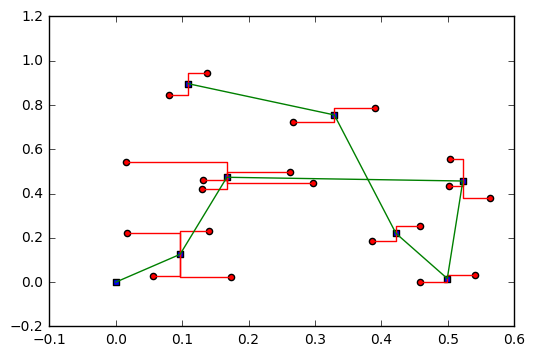

2.267693042755127 seconds


'\nfor i in range(1, 8):\n    returnAverageCostInfo(50, i, 1, seed = 0)\n    '

In [41]:
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
from scipy.cluster.vq import kmeans 
import numpy as np
import itertools
import time

#Genetic Algorithm for Bus Stops with K-Means Stop Selection:

#Constants Used
#mph
bus_speed = 20
walking_speed = 3
# dollars/hour
student_value = 4.5
driver_value = 15
# dollar/mile
mile_cost = 1


def manhattan(a,b):
    return abs(a[0]-b[0])+abs(a[1]-b[1])
def distance(a,b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

def plotWalkingDistance(students, stops):
    findWalkingDistance(students, stops, plot = 1)
    
def findWalkingDistance(students, stops, plot = 0):
    totalWalkingDistance = 0
    for student in students:
        minDistance = -1
        closestStop = stops[0]
        for stop in stops:
            if minDistance < 0:
                minDistance = manhattan(student, stop)
                closestStop = stop
            elif manhattan(student,stop)<minDistance:
                minDistance = manhattan(student, stop)
                closestStop = stop
        #plt.plot([student[0], closestStop[0]], [student[1], closestStop[1]],'r')
        if(plot):
            plotManhattan(student, closestStop)
        totalWalkingDistance+=minDistance
    return totalWalkingDistance
def plotManhattan(point1, point2, color = 'r'):
    if(color != 'r'):
        plt.plot([point1[0], point2[0], point2[0]], [point1[1], point1[1], point2[1]],color)
    else:
        plt.plot([point1[0], point2[0], point2[0]], [point1[1], point1[1], point2[1]],'r')

def demoTrial(students_size, stop_count):
    students_size = 40
    stop_count = 5
    randomStudents = [(random.random()*3/5, random.random()) for i in range(0, students_size)]
    x,y = zip(*randomStudents)
    stops = kmeans(randomStudents, stop_count) [0]
    s_x, s_y = stops[:,0], stops[:,1] #splices the x and y column data
    plt.scatter(x,y)
    plt.scatter(s_x, s_y, color = 'r')
    totalWalk = plotConnections(randomStudents, stops)
    plt.show()
    print(totalWalk)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p[0] for p in points], [p[1] for p in points]    
def plotList(points, color = None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, color=color)
    else:
        plt.plot(X, Y)
def plotManhattanList(points, color=None):
    for i in range(0, len(points)):
        plotManhattan(points[i-1], points[i], color)
        
def all_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(list(cities) - {start})]

def first(something):
    #returns first element of set
    for thing in something:
        return thing
    
def modify_stop_array(stops, students):
    """modifies the stops array so that a column that contains the number of students that get off at each stop is added. The
    purpose of this is to enable the route calculation algorithm to weight the total cost function based on the number
    of students remaining on the bus"""
    if type(stops) == list:
        z = np.zeros((len(stops),1))
    else:
        z = np.zeros((stops.size/stops[0].size,1))
    stops = np.append(stops, z, axis=1)
    for student in students:
        minDistance = -1
        closestStop = stops[0]
        for stop in stops:
            if minDistance < 0:
                minDistance = manhattan(student, stop)
                closestStop = stop
            elif manhattan(student,stop)<minDistance:
                minDistance = manhattan(student, stop)
                closestStop = stop
        #adds one to the stop counter
        closestStop[2]+=1
    return stops
def calculateRoute(students, stops):
    #outputs [distance, time, total weighted student bus time]
    modifiedStops = modify_stop_array(stops, students)
    totalDistance = 0
    totalTime = 0
    studentTime = 0
    studentsLeft = len(students)
    
    for i in range(len(modifiedStops)):
        #from last stop to first stop, there are no students!
        change = manhattan(modifiedStops[i-1], modifiedStops[i])
        totalDistance += change
        totalTime += change/bus_speed
        if (i-1)>=0:
            studentTime += change/bus_speed*studentsLeft
            studentsLeft -= modifiedStops[i][2]
            #print(studentsLeft)
    return [totalDistance, totalTime, studentTime]

def cost(students, stops, absolute = 'no'):
    #don't forget to append (0,0) before this...
    #outputs the cost of the route in the specified order
    totalWalkDistance = findWalkingDistance(students, stops)
    total_walk_time = totalWalkDistance / walking_speed
    trip_distance, trip_time, students_total_time = calculateRoute(students, stops)
    if(absolute == 'no'):
        return float(total_walk_time+students_total_time)*student_value
        +trip_time*driver_value
        +mile_cost*trip_distance
    else:
        return float(trip_time*driver_value+mile_cost*trip_distance)
    
def all_non_redundant_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(cities[1:])]

def best(students, stops): 
    "Return the tour with the minimum total cost."
    all_stops = all_non_redundant_tours(stops)
    min_cost_stops = first(all_stops)
    min_cost = cost(students,min_cost_stops)
    for stops in all_stops:
        temp_cost = cost(students, stops) 
        if temp_cost < min_cost:
            min_cost_stops = stops
            min_cost = temp_cost
    return np.array(min_cost_stops)
def shortest(students, stops):
    all_stops = all_non_redundant_tours(stops)
    min_cost_stops = first(all_stops)
    min_dist = calculateRoute(students, min_cost_stops)[0]
    for stops in all_stops:
        temp_dist = calculateRoute(students, stops)[0]
        if temp_dist < min_dist:
            min_cost_stops = stops
            min_dist = temp_dist
    return np.array(min_cost_stops)

def runModel(students_size, stop_count, trials, seed = 'variable', plot = True):
    arrayOfCosts = []
    arrayOfInformation = []
    
    for i in range(0,trials):
        if seed == 'variable':
            random.seed(i)
        else:
            random.seed(seed)
        randomStudents = [(random.random()*3/5, random.random()) for i in range(0, students_size)]
        x,y = zip(*randomStudents)
        stops = kmeans(randomStudents, stop_count) [0]
        if(plot):
            plotWalkingDistance(randomStudents, stops)
        stops = np.insert(stops, 0, (0,0), axis=0)
        
        #plotList(stops, 'g')
        
        #beststops = best(randomStudents, stops)
        beststops = best(randomStudents, stops)
        if plot:
            plt.scatter(x,y, c = 'r')
            print(beststops)
            s_x, s_y = beststops[:,0], beststops[:,1] #splices the x and y column data
            plt.scatter(s_x, s_y, c = 'b', marker='s')
            plotList(beststops, 'g')
        
        #distance, time, student time
        routeInfo = calculateRoute(randomStudents, beststops)
        if plot:
            print(routeInfo)
        arrayOfInformation.append(routeInfo)
        tempCost = cost(randomStudents, beststops)
        arrayOfCosts.append(tempCost)
        if plot:
            print(tempCost)
            plt.show()
    return (arrayOfCosts, arrayOfInformation)
def returnAverageCostInfo(students_size, stops_size, trials, seed = 0):
    #average, stdev
    results = runModel(students_size, stops_size, trials, plot = False, seed = seed)
    print("Cost information for %d, %d"  %(students_size, stops_size))
    print (np.sum(results[0])/trials, np.std(results[0]))
    return (np.sum(results[0])/trials, np.std(results[0]))
time1 = time.time()
runModel(20,7,1, seed = 1)
print(str(time.time()-time1) + " seconds")
"""
for i in range(1, 8):
    returnAverageCostInfo(50, i, 1, seed = 0)
    """

#s_x, s_y = stops[:,0], stops[:,1] #splices the x and y column data
#demoTrial(50, 8)

C:\Users\Jiedong\Anaconda3\lib\site-packages\ipykernel\__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


8.26189398765564 seconds
Fitness of the best individual:  7.37621783319063


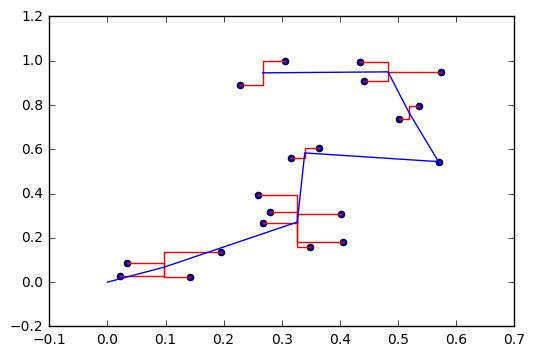

In [42]:
#Genetic Algorithm Code

#initialization
import time
import operator
import numpy
from deap import algorithms, base, creator, tools
toolbox = base.Toolbox()

#self explanatory
students_size = 20
stop_count = 7

#sets the scenario. Comment out the folloiwng line for a random scenario
random.seed(2)

students = [(random.random()*3/5, random.random()) for i in range(0, students_size)]
x,y = zip(*students)
    
stops = kmeans(students, stop_count) [0]
while stops.shape[0]<stop_count:
     stops = np.insert(stops, 0, (0,0), axis=0)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("indices", numpy.random.permutation, stop_count)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

def create_tour(individual):
    return np.insert([stops[e] for e in individual], 0, (0,0), axis=0)

def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (cost(students, create_tour(individual)),)

toolbox.register("evaluate", evaluation)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=100)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
 

fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

time1 = time.time()
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=200, verbose=False, stats = fit_stats)
#logs amount of time used
print(str(time.time()-time1) + " seconds")

best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

plt.scatter(x,y)
plotWalkingDistance(students, stops)
plotList(create_tour(best_individual))
plt.show()


In [43]:
#Converts the best individual into a form that can be processed by the cost function and outputs this cost
best_route = create_tour(best_individual)
print(best_individual)
print(cost(students, best_route))
print(calculateRoute(students, best_route))

#Code to plot the convergence of the GA




[5, 6, 1, 4, 2, 3, 0]
7.37621783319063
[3.1177263674583564, 0.1558863183729178, 1.0414958693954719]


C:\Users\Jiedong\Anaconda3\lib\site-packages\ipykernel\__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


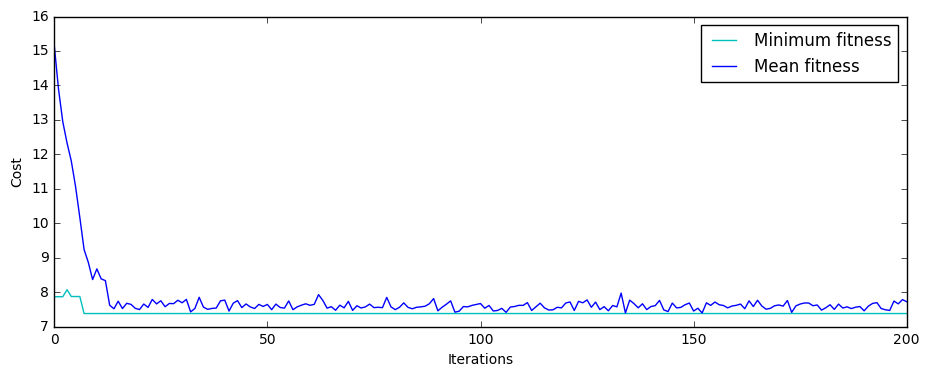

In [44]:
plt.figure(1, figsize=(11, 4), dpi=500)
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-', antialiased=True)
plt.legend(plots, ('Minimum fitness', 'Mean fitness'))
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.show()